# New Analysis for DRD87 during day 6 Veh

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..", "..")))

import pandas as pd
import numpy as np
from analysis import sig_proc
from analysis.graph_analysis_utils import NeuronNetwork
from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell

In [2]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/New_Analysis")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: Rearing - D87_Day6_SUL_corrected.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/New_Analysis/Rearing - D87_Day6_SUL_corrected.csv
1. full path of: D87_Day1_A1_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/New_Analysis/D87_Day1_A1_raw.csv
2. full path of: D87_Day1_A2_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/New_Analysis/D87_Day1_A2_raw.csv
3. full path of: D87_Day6_sul_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/New_Analysis/D87_Day6_sul_raw.csv
4. full path of: Rearing - D87_Day1_A2.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/New_Analysis/Rearing - D87_Day1_A2.csv
5. full path of: Rearing - D87_Day1_A1.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/New_Analysis/Rearing - D87_Day1_A1.csv
6. full path of: Rearing - D87_Day6_VEH_corrected.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/New_Analysis/Rearing - D87_Day6_VEH_corrected.csv
7. full path of: D87_Day6_veh_raw.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/New_Analysis/D87_Day6_veh_raw.csv


In [4]:
drd87_data = pd.read_csv(raw_files[7], header=None)
drd87_data = FeatureExtractor.downsample_dataframe(drd87_data, 2)
_, auc_dataframe, cell_transients_dataframe = sig_proc.detect_ca_transients_mossy(drd87_data, 2, 0.5, 0.2, 10)

behavior_df = pd.read_csv(raw_files[6])

# Drop unnecessary columns from behavior dataframe
behavior_df.drop(columns=["Observation", "Event Log", "Time", "Rearing"], inplace=True)

drd87_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, row_multiple=2)

In [5]:
# Find the difference in length between the neural signal dataframe and the behavior dataframe
height_diff = len(drd87_fe.auc_df) - len(drd87_fe.behavior_df)

# We append an n amount of rows into the behavior dataframe "Rear" column, in order to make it aligned with the neural signal data dataframe.
last_row = len(drd87_fe.behavior_df)

# Create a list of dictionaries to append as rows to the "Rear" column 
rows_list = []
for _ in range(height_diff):
    rows_list.append({"Rear": 0})
    
# Append the list of dictionaries to the rows list to align the behavior dataframe with the neural signal dataframe
drd87_fe.behavior_df = drd87_fe.behavior_df.append(rows_list, ignore_index=True)

# Finally, we add another behavior column, "NOT_Rear" that is the logical NOT of the "Rear" column
drd87_fe.behavior_df = drd87_fe.behavior_df.assign(NOT_Rear = 1-drd87_fe.behavior_df["Rear"])

In [6]:
drd87_fe.neuron_concated_behavior = drd87_fe.auc_df.join(drd87_fe.behavior_df, how="left")

In [7]:
def bin_by_time(dataframe, **kwargs):
    """Split dataframe by frequency
    
    Split up the time series data into specified time bins. 
    
    Args: 
        dataframe: DataFrame
        
            a pandas DataFrame of the signal data for 
            all the imaged neurons of a given animal activity.
        
        freq: string, optional
            
            If specified, this is the frequency by which the 
            passed DataFrame will be split. The default is 
            1Min.
    
    Returns: 
        time_bins: dictionary
            
            All of the DataFrames that encompasse the passed-in
            DataFrame.
    """
    
    # Create copy of the dataframe for a certain behavior
    time_binned_df = dataframe.copy()
    time_binned_df.reset_index(drop=True, inplace=True)
    
    # Add a column of the trial time in the form of time deltas
    x = pd.to_timedelta("0.1s")
    time_binned_df.loc[:, "TIME"] = pd.Series(x*i for i in (time_binned_df.index))
    
    # Group the dataframe by 1 minute intervals
    grouped = time_binned_df.set_index("TIME").groupby(pd.Grouper(freq=kwargs.get("freq", "1Min")))
    
    # Place each dataframe that contains the data for every 1 minute intervals into a dictionary
    time_bins = {}
    freq = 0
    for name, group in grouped:
        time_bins[freq] = grouped.get_group(name)
        freq += 1
        
    return time_bins

## 1. Average rate over time (eg. average rate for each minute) during Day 1 A1.

In [8]:
df_per_minute = bin_by_time(drd87_fe.neuron_concated_behavior)

for minute in df_per_minute:
    print("Minute: {}, avg rate: {}".format(minute, 10 * df_per_minute[minute].loc[:, drd87_fe.auc_df.columns].mean().mean()))

Minute: 0, avg rate: 5.4208974277464765
Minute: 1, avg rate: 2.4735903838320885
Minute: 2, avg rate: 2.6021796382114486
Minute: 3, avg rate: 2.3097284086079437
Minute: 4, avg rate: 1.7949441180512535
Minute: 5, avg rate: 1.6771988755748213
Minute: 6, avg rate: 1.8535063722298588
Minute: 7, avg rate: 2.570597197815558
Minute: 8, avg rate: 1.703806938656221
Minute: 9, avg rate: 1.8853665091581517
Minute: 10, avg rate: 2.0810323523965217


## 2. Average rate during rearing

In [9]:
10 * drd87_fe.neuron_concated_behavior.loc[drd87_fe.neuron_concated_behavior["Rear"] != 0, drd87_fe.auc_df.columns].mean().mean()

7.028244683774477

## 3: Cell selectivity for rearing (are there rearing selective cells?)

In [10]:
drd87_real_diff_vals = drd87_fe.set_real_diff_df(drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "Rear", "NOT_Rear")
drd87_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:109: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron88,neuron89,neuron90,neuron91,neuron92,neuron93,neuron94,neuron95,neuron96,neuron97
D,-2.76601,-0.00690396,2.26419,8.50557,5.15472,4.25758,22.3112,-1.61311,-2.34119,-1.59065,...,-3.09944,1.6589,1.84276,-0.144526,2.71138,5.84483,-0.232882,0.128551,-2.65092,4.42234


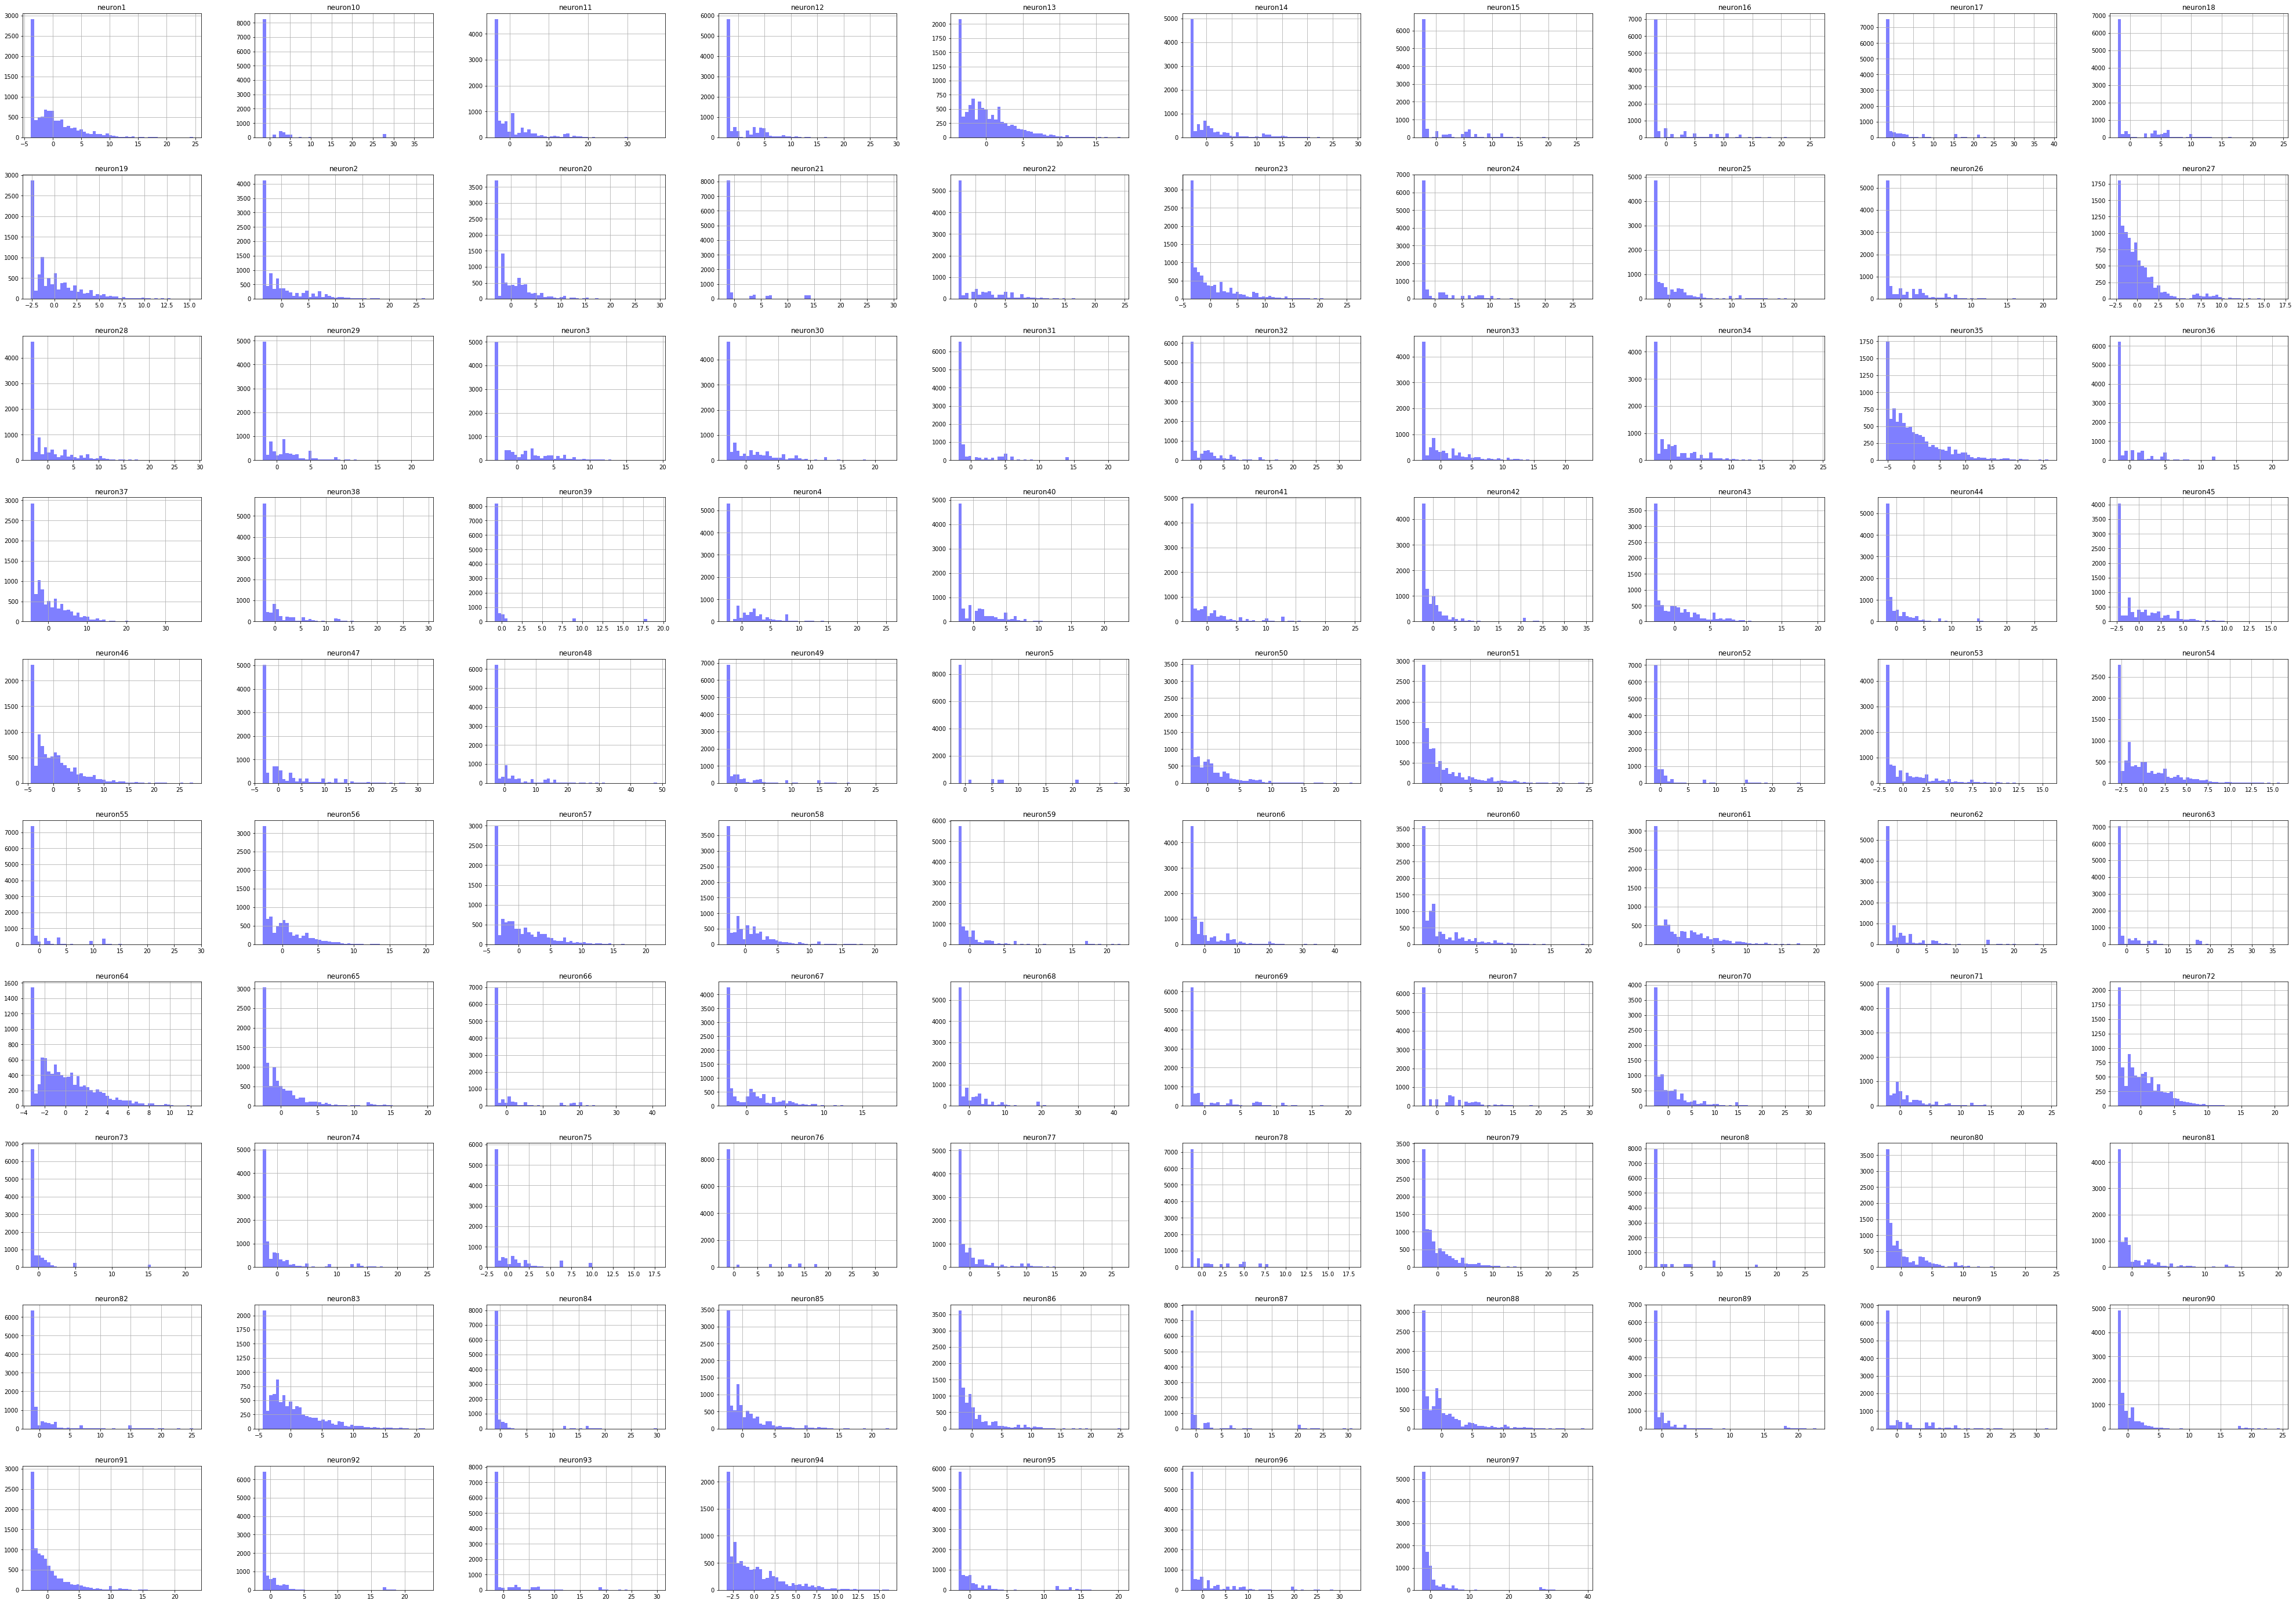

In [11]:
resampled_df = Resampler.shuffle(10000, drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "Rear", "NOT_Rear")
resampled_df.hist(alpha=0.5, color="blue", bins=50, figsize=(70, 50));

In [12]:
drd87_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_fe.auc_df, resampled_df, drd87_real_diff_vals, p_value=0.05, threshold=10)
drd87_neurons_by_beh = Resampler.classify_by_behavior(drd87_classified_neurons, drd87_real_diff_vals, "Rear", "NOT_Rear")

In [13]:
drd87_neurons_by_beh

{'neuron5': 'unclassified',
 'neuron8': 'unclassified',
 'neuron10': 'unclassified',
 'neuron21': 'unclassified',
 'neuron39': 'unclassified',
 'neuron76': 'unclassified',
 'neuron1': 'not-selective',
 'neuron2': 'not-selective',
 'neuron3': 'not-selective',
 'neuron4': 'Rear',
 'neuron6': 'not-selective',
 'neuron7': 'Rear',
 'neuron9': 'not-selective',
 'neuron11': 'Rear',
 'neuron12': 'not-selective',
 'neuron13': 'not-selective',
 'neuron14': 'not-selective',
 'neuron15': 'not-selective',
 'neuron16': 'Rear',
 'neuron17': 'Rear',
 'neuron18': 'not-selective',
 'neuron19': 'not-selective',
 'neuron20': 'not-selective',
 'neuron22': 'not-selective',
 'neuron23': 'not-selective',
 'neuron24': 'not-selective',
 'neuron25': 'Rear',
 'neuron26': 'not-selective',
 'neuron27': 'not-selective',
 'neuron28': 'Rear',
 'neuron29': 'not-selective',
 'neuron30': 'Rear',
 'neuron31': 'Rear',
 'neuron32': 'not-selective',
 'neuron33': 'Rear',
 'neuron34': 'not-selective',
 'neuron35': 'Rear',
 'ne